# Training a multi-task regression model for neural crest cells

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata

## Set experiment parameters

In [3]:
experiment = 'multi_task_1'
if not os.path.exists(experiment):
    os.makedirs(experiment)
    
genome = 'danRer11' #"GRCz11"
seq_len = 200 # Length of the input sequence

## Load Data

In [4]:
peaks = pd.read_csv("../data/normalized_peaks.csv")

ad = peaks.to_numpy()
ad = anndata.AnnData(ad).T

# Prepare ad.obs
cell_types = pd.DataFrame({'cell type': peaks.columns})
ad.obs = cell_types
ad.obs_names = ad.obs['cell type']

# Prepare ad.var
var = pd.read_csv("../data/chromosomes.10hpf.bed", sep = '\t', header = None)
var.columns = ['chrom', 'start', 'end', 'name', 'score', 'strand']
var = var.drop(columns =['name', 'score', 'strand'])
var.index = var.index.astype(str)
ad.var = var

ad.shape

(15, 370058)

In [5]:
ad.obs

,cell type
cell type,
anterior/posterior axis,anterior/posterior axis
central nervous system,central nervous system
forebrain,forebrain
immature eye,immature eye
integument,integument
lateral plate mesoderm,lateral plate mesoderm
mesenchyme cell,mesenchyme cell
musculature system,musculature system
neural crest,neural crest


In [6]:
ad.obs_names

Index(['anterior/posterior axis', 'central nervous system', 'forebrain',
       'immature eye', 'integument', 'lateral plate mesoderm',
       'mesenchyme cell', 'musculature system', 'neural crest', 'neural keel',
       'neural stem cell', 'periderm/epidermis', 'primary neuron',
       'segmental plate', 'YSL'],
      dtype='object', name='cell type')

In [7]:
ad.var.head()

,chrom,start,end
0,chr1,5231,5732
1,chr1,5786,6287
2,chr1,10087,10588
3,chr1,10990,11491
4,chr1,11894,12395


In [8]:
ad.X[0:5,0:5]

array([[4.65111754, 4.7597768 , 4.84433467, 4.91311991, 5.09123001],
       [4.53367234, 4.71507734, 4.6939733 , 4.97038916, 5.15560569],
       [3.74337616, 3.89092058, 3.71531718, 4.50199984, 4.58080749],
       [4.67651185, 4.80295157, 4.32103392, 4.53860808, 4.89682671],
       [3.88919404, 3.75913911, 3.88919404, 4.40643606, 4.7314921 ]])

## Select small dataset for testing

In [9]:
ad = ad[:,:50000]
ad.shape

(15, 50000)

## Filter peaks

Performing filtering of the dataset using `grelu.data.preprocess` module.

First, we filter peaks within autosomes (chromosomes 1 - 22) or chromosomes X/Y.

In [10]:
import grelu.data.preprocess

ad = grelu.data.preprocess.filter_chromosomes(ad, 'autosomes')

Keeping 50000 intervals


## Resize peaks

ATAC-seq peaks can take different lengths. Hence, we resize all ATAC-seq peaks to a constant sequence length of 200 bp to train the model as follows:

In [11]:
import grelu.sequence.utils


ad.var = grelu.sequence.utils.resize(ad.var, seq_len)
ad.var.head(3)

,chrom,start,end
0,chr1,5382,5582
1,chr1,5937,6137
2,chr1,10238,10438


## Split data

In [12]:
ad.var['chrom'].unique()

array(['chr1', 'chr2', 'chr3', 'chr4'], dtype=object)

In [13]:
train_chroms='autosomes'
val_chroms=['chr3']
test_chroms=['chr4']


ad_train, ad_val, ad_test = grelu.data.preprocess.split(
    ad, 
    train_chroms = train_chroms, val_chroms = val_chroms, 
    test_chroms = test_chroms,
)

Selecting training samples
Keeping 32368 intervals


Selecting validation samples
Keeping 17079 intervals


Selecting test samples
Keeping 553 intervals
Final sizes: train: (15, 32368), val: (15, 17079), test: (15, 553)


## Make labeled sequence datasets

In [14]:
import grelu.data.dataset

In [15]:
train_dataset = grelu.data.dataset.AnnDataSeqDataset(
    ad_train.copy(),
    genome = genome,
    rc = True, #reverse complement
    max_seq_shift = 1, # Shift the sequence
    augment_mode = "random", # Randomly select which augmentations to apply
)

In [16]:
val_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_val.copy(), genome=genome)
test_dataset = grelu.data.dataset.AnnDataSeqDataset(ad_test.copy(), genome=genome)

## Build model

Here we use the DiltatedConvModel

In [17]:
model_params = {
    'model_type':'DilatedConvModel', # Type of model
    'n_tasks': ad.shape[0], # Number of cell types to predict
    'crop_len':0, # No cropping of the model output. What does this really mean?
    'channels':512,
    'n_conv':8,
}

train_params = {
    'task':'regression', # regression
    'loss': 'mse', 
    'lr': 1e-4, # learning rate
    'logger': 'csv', # Logs will be written to a CSV file
    'batch_size':512,
    'max_epochs':10,
    'devices':0, # Either “cpu” or an integer or list of integers representing the indices of the GPUs for training
    'num_workers':8,
    'optimizer': 'adam',
    'save_dir':experiment,
    'checkpoint': True, # Save checkpoints
}

import grelu.lightning
model = grelu.lightning.LightningModel(model_params, train_params)

## Train model

In [18]:
# See the 'single_task_1' folder for logs
trainer = model.train_on_dataset(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


Validation: |          | 0/? [00:00<?, ?it/s]

/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32). Setting the correlation coefficient to nan.
  warnings.warn(*args, **kwargs)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss              7.5404052734375
         val_mse             7.466798782348633
       val_pearson                  nan
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | model        | DilatedConvModel | 5.6 M  | train
1 | loss         | MSELoss          | 0      | train
2 | activation   | Identity         | 0      | train
3 | val_metrics  | MetricCollection | 0      | train
4 | test_metrics | MetricCollection | 0      | train
5 | transform    | Identity         | 0      | train
----------------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.239    Total estimated model params size (MB)
119       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32). Setting the correlation coefficient to nan.
  warnings.warn(*args, **kwargs)
/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Load best model from checkpoint

In [19]:
best_checkpoint = trainer.checkpoint_callback.best_model_path
print(best_checkpoint)
model = grelu.lightning.LightningModel.load_from_checkpoint(best_checkpoint)

multi_task_1/2025_01_04_23_11/version_0/checkpoints/epoch=8-step=576.ckpt


## Evaluate model on the test set

In [20]:
test_metrics = model.test_on_dataset(
    test_dataset,
    devices=0,
    num_workers=8,
    batch_size=256,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.14989173412323
        test_mse            1.2708117961883545
      test_pearson          0.27944356203079224
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Run inference on held out sequences

In [155]:
preds = model.predict_on_dataset(
    test_dataset, devices=0, num_workers=8
    )
preds.shape

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |          | 0/? [00:00<?, ?it/s]

(553, 15, 1)

In [229]:
preds_df = model.predict_on_dataset(
    test_dataset, devices=0, num_workers=8,
    return_df=True # Return the output as a pandas dataframe
    )
preds_df.head()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |          | 0/? [00:00<?, ?it/s]

,anterior/posterior axis,central nervous system,forebrain,immature eye,integument,lateral plate mesoderm,mesenchyme cell,musculature system,neural crest,neural keel,neural stem cell,periderm/epidermis,primary neuron,segmental plate,YSL
0,2.557983,2.550827,2.401309,2.474052,2.473516,2.509418,2.527504,2.480300,2.555627,2.589838,2.479392,2.504568,2.553500,2.469495,2.469913
1,2.323212,2.274002,2.204450,2.274616,2.278533,2.246181,2.301822,2.308701,2.314971,2.329458,2.272476,2.355713,2.343838,2.234186,2.377474
2,2.215655,2.159862,2.105978,2.169221,2.205518,2.139402,2.197649,2.219125,2.190884,2.207607,2.177018,2.302426,2.253222,2.131030,2.359608
3,2.948264,2.994882,2.787483,2.846636,2.854085,2.932945,2.974338,2.843128,2.991907,3.036384,2.903981,2.780143,2.970635,2.891930,2.644167
4,2.687939,2.709838,2.529444,2.587805,2.592871,2.634660,2.698400,2.622320,2.698676,2.737927,2.619337,2.594745,2.691043,2.618878,2.509019


In [22]:
import grelu.visualize

/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/grelu/visualize.py:191: UserWarning: Currently density plot cannot be faceted due to plotnine issues. All tasks will be combined.


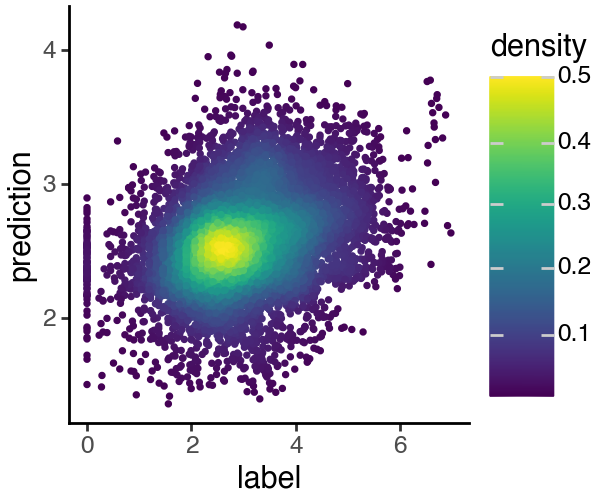

In [23]:
grelu.visualize.plot_pred_scatter(
    preds=preds,
    labels=test_dataset.get_labels(),
    density=True, # Color points by local density
    figsize=(3, 2.5), # width, height
    size=.5
)

## Correlations for each cell type in test set

In [185]:
from torchmetrics.regression import PearsonCorrCoef
import torch 

preds_2d = preds.squeeze(-1)  # [batch_size * seq_len, num_tasks]
preds_2d = torch.from_numpy(preds_2d)
target_2d = test_dataset.get_labels().squeeze(-1)
target_2d = torch.from_numpy(target_2d)

coeff = PearsonCorrCoef(num_outputs=15)
coeff.update(preds_2d, target_2d)

# Compute result
result = coeff.compute()
print(result)


tensor([0.2990, 0.3258, 0.2218, 0.2513, 0.2763, 0.3392, 0.3037, 0.2501, 0.3099,
        0.3412, 0.2697, 0.2353, 0.2569, 0.3164, 0.1950])


In [192]:
corr_cells = pd.DataFrame({'cell_type': ad_test.obs['cell type'], 
                          'pearson correlation': result} )
corr_cells = corr_cells.reset_index().drop(columns= 'cell_type')

corr_cells.to_csv('../results/cell_type_pearson_corr.csv', index=False)

In [199]:
corr_cells.sort_values(by='pearson correlation', ascending= False)

,cell type,pearson correlation
9,neural keel,0.341200
5,lateral plate mesoderm,0.339221
1,central nervous system,0.325762
13,segmental plate,0.316388
8,neural crest,0.309884
6,mesenchyme cell,0.303680
0,anterior/posterior axis,0.299018
4,integument,0.276290
10,neural stem cell,0.269711
12,primary neuron,0.256930


## Interpret model predictions (for neural keel) using TF-modisco

In [230]:
from grelu.transforms.prediction_transforms import Aggregate

neural_keel_peaks = Aggregate(
    tasks = ["neural keel"],
    model = model,
)

neural_keel_peaks

Aggregate()

In [231]:
ad_test.var

,chrom,start,end
49447,chr4,1516,1716
49448,chr4,3091,3291
49449,chr4,4555,4755
49450,chr4,6099,6299
49451,chr4,12813,13013
...,...,...,...
49995,chr4,1235799,1235999
49996,chr4,1239478,1239678
49997,chr4,1243254,1243454
49998,chr4,1245149,1245349


The regulatory motifs for Zebra fish (Danio Rerio) were obtained from the [`SwissRegulon Portal`](https://swissregulon.unibas.ch/data/dr11/dr11_weight_matrices) as produced by the publication:

Baranasic, D., Hörtenhuber, M., Balwierz, P.J. et al. Multiomic atlas with functional stratification and developmental dynamics of zebrafish cis-regulatory elements. Nat Genet 54, 1037–1050 (2022). https://doi.org/10.1038/s41588-022-01089-w

Furthermore, the regulatory motifs (weight matrices) was converted from its original TRANSFAC 'matrix.dat' file into a MEME motif file by using the `transfac2meme` motif conversion utility from the [`The MEME Suite`](https://web.mit.edu/meme_v4.11.4/share/doc/transfac2meme.html).



In [240]:
%%time
import grelu.interpret.modisco
grelu.interpret.modisco.run_modisco(
    model,
    seqs=ad_test.var, 
    genome=genome,
    prediction_transform=neural_keel_peaks, # Base importance scores will be calculated with respect to this output
    meme_file="../data/danRer11.meme", # We will compare the Modisco CWMs to HOCOMOCO motifs
    method="ism", # Base-level attribution scores will be calculated using ISM. You can also use "saliency".
    out_dir=experiment,
    batch_size=256,
    devices=0,
    num_workers=8,
    window=100, # ISM scores will be calculated over the central 100 bp of each peak
    seed=0,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Performing ISM


/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: UserWarning: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Running modisco
Writing modisco output
Creating sequence logos
Creating html report
Running TOMTOM
CPU times: user 6.45 s, sys: 4.51 s, total: 11 s
Wall time: 4min 50s


In [234]:
import grelu.resources

grelu.resources.get_meme_file_path(meme_motif_db = 'consensus') 

'/Users/victoremenike/anaconda3/envs/deeplife/lib/python3.11/site-packages/grelu/resources/meme/jaspar_2024_consensus.meme'